# ML Prague - Word Embeddings 1: Word2Vec & Application
Objectives of this notebook:
1. Demonstrate training/utilization of a `Word2Vec` model using `Gensim`.
2. Familiarization with `Gensim` APIs.
3. Application of word embeddings on a supervised text classification task.

### Requirements:
- Python3.5
- gensim
- pandas
- matplotlib
- sklearn

In [1]:
# imports

from __future__ import print_function
import logging
import gensim
from gensim.models import Word2Vec, KeyedVectors
from gensim.models.word2vec import Text8Corpus
from gensim.parsing import preprocess_string
from gensim.parsing.preprocessing import strip_punctuation, strip_numeric, strip_multiple_whitespaces, strip_short
import gensim.downloader as api
import numpy as np
from collections import defaultdict
import multiprocessing
from smart_open import smart_open

In [2]:
# ensure FAST_VERSION > -1 - would be painfully slow to train models otherwise.
# A good BLAS library is recommended to make use of heavy low level optimisations.
gensim.models.word2vec.FAST_VERSION

1

In [3]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

## Training a `Word2Vec` model
Train a Word2Vec model on `text8`.

### Input to model
> Keeping the input as a Python built-in list is convenient, but can use up a lot of RAM when the input is large.
> Gensim only requires that the input must provide sentences sequentially, when iterated over. No need to keep everything in RAM: we can provide one sentence, process it, forget it, load another sentence…

The input to `Word2Vec` can be simply a list of lists of tokens, but for larger corpora, it is better to give it an iterable that streams the sentences directly from disk/network.

In [4]:
# a memory-friendly iterator
# text8_corpus = Text8Corpus('./data/text8')
text8_corpus = api.load("text8")

In [5]:
%%time
# train a `Word2Vec` model on text8 corpus
model_text8 = Word2Vec(text8_corpus, size=50, iter=5, workers=multiprocessing.cpu_count())

2018-03-17 18:29:30,674 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2018-03-17 18:29:30,677 : INFO : collecting all words and their counts
2018-03-17 18:29:30,688 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-03-17 18:29:34,698 : INFO : collected 253854 word types from a corpus of 17005207 raw words and 1701 sentences
2018-03-17 18:29:34,698 : INFO : Loading a fresh vocabulary
2018-03-17 18:29:34,906 : INFO : min_count=5 retains 71290 unique words (28% of original 253854, drops 182564)
2018-03-17 18:29:34,906 : INFO : min_count=5 leaves 16718844 word corpus (98% of original 17005207, drops 286363)
2018-03-17 18:29:35,053 : INFO : deleting the raw counts dictionary of 253854 items
2018-03-17 18:29:35,065 : INFO : sample=0.001 downsamples 38 most-common words
2018-03-17 18:29:35,066 : INFO : downsampling leaves estimated 12506280 word corpus (74.8% of prior 16718844)
2018-03-17 18:29:35,269 : INFO : estimated requir

2018-03-17 18:30:13,430 : INFO : worker thread finished; awaiting finish of 4 more threads
2018-03-17 18:30:13,431 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-03-17 18:30:13,432 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-03-17 18:30:13,434 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-03-17 18:30:13,439 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-03-17 18:30:13,439 : INFO : EPOCH - 4 : training on 17005207 raw words (12505202 effective words) took 9.8s, 1272366 effective words/s
2018-03-17 18:30:14,443 : INFO : EPOCH 5 - PROGRESS: at 10.29% examples, 1275578 words/s, in_qsize 0, out_qsize 0
2018-03-17 18:30:15,450 : INFO : EPOCH 5 - PROGRESS: at 20.75% examples, 1286140 words/s, in_qsize 0, out_qsize 0
2018-03-17 18:30:16,456 : INFO : EPOCH 5 - PROGRESS: at 31.16% examples, 1293229 words/s, in_qsize 0, out_qsize 1
2018-03-17 18:30:17,458 : INFO : EPOCH 5 - PROGRESS: at 42.15% 

CPU times: user 2min 21s, sys: 456 ms, total: 2min 21s
Wall time: 52.3 s


In [6]:
print('Vocabulary size: %d' % len(model_text8.wv.vocab))
print('Word embeddings matrix shape: %s' % str(model_text8.wv.vectors.shape))

Vocabulary size: 71290
Word embeddings matrix shape: (71290, 50)


In [7]:
# get a word's vector
print(model_text8.wv['cat'].shape)
print(model_text8.wv['cat'])
print(model_text8.wv.word_vec('cat', use_norm=False))

(50,)
[ 2.8120091e+00 -4.4274482e-01 -1.2171491e-01 -1.1067118e-01
 -3.4908062e-01 -8.6004508e-01 -1.8854939e+00 -3.0238085e+00
 -1.2976211e+00  2.0229805e-01  7.6597488e-01 -6.6948879e-01
  8.7617785e-01  5.1289356e-01 -4.9695468e-01  7.1485177e-02
  1.6823003e+00 -2.6944602e+00 -3.2400355e-01  6.1904854e-01
  2.1600552e+00  3.9656472e-01  3.6598623e-01  7.2499603e-01
 -8.0536604e-01 -1.6124638e+00  1.0816779e+00  1.3378210e+00
 -1.0271267e+00  5.9613442e-01  1.2789030e+00 -1.4804765e+00
  1.5649840e+00 -4.5707607e-01  8.1829834e-01  2.3345325e+00
 -7.8127226e-03 -1.5305336e-01  1.8449184e+00 -8.1483310e-01
  1.4861569e+00 -1.5639691e+00 -1.1471926e+00 -1.3460046e+00
 -4.2964953e-01  3.8233975e-01 -1.1196358e+00 -5.4196471e-01
 -2.1623047e-03  2.1009531e+00]
[ 2.8120091e+00 -4.4274482e-01 -1.2171491e-01 -1.1067118e-01
 -3.4908062e-01 -8.6004508e-01 -1.8854939e+00 -3.0238085e+00
 -1.2976211e+00  2.0229805e-01  7.6597488e-01 -6.6948879e-01
  8.7617785e-01  5.1289356e-01 -4.9695468e-01  

In [8]:
# get a word's normalized vector
model_text8.wv.init_sims()
print(model_text8.wv.word_vec('cat', use_norm=True))

2018-03-17 18:30:48,502 : INFO : precomputing L2-norms of word weight vectors


[ 3.14031631e-01 -4.94436063e-02 -1.35925347e-02 -1.23592233e-02
 -3.89836431e-02 -9.60456878e-02 -2.10562870e-01 -3.37684363e-01
 -1.44912079e-01  2.25916710e-02  8.55403841e-02 -7.47652799e-02
  9.78473201e-02  5.72774820e-02 -5.54975048e-02  7.98312016e-03
  1.87871188e-01 -3.00904334e-01 -3.61831561e-02  6.91323578e-02
  2.41224542e-01  4.42864373e-02  4.08715792e-02  8.09640586e-02
 -8.99394006e-02 -1.80072188e-01  1.20796576e-01  1.49401397e-01
 -1.14704557e-01  6.65734187e-02  1.42821729e-01 -1.65332481e-01
  1.74769863e-01 -5.10440543e-02  9.13836136e-02  2.60709345e-01
 -8.72487202e-04 -1.70922615e-02  2.06031591e-01 -9.09966305e-02
  1.65966839e-01 -1.74656540e-01 -1.28112942e-01 -1.50315300e-01
 -4.79811877e-02  4.26978581e-02 -1.25035524e-01 -6.05240054e-02
 -2.41475762e-04  2.34624311e-01]


## Online training
Continue training on more corpus/data. The new corpus can have new vocabulary words.

In [9]:
# Gensim only requires that the input must provide sentences sequentially, when iterated over.
# yield one sentence (list of utf8 words) after another.
class MySentences(object):
    def __init__(self, filename):
        self._fname = filename

    def __iter__(self):
        for line in smart_open(self._fname, 'rb'):
            cleaned_words = [word for word in preprocess_string(line.decode('utf-8'))]
            if cleaned_words:
                yield cleaned_words

In [10]:
new_sentences = MySentences('data/article-about-rare-words.txt')

In [11]:
# update vocabulary with new words (if any)
model_text8.build_vocab(new_sentences, update=True, min_count=1)

2018-03-17 18:31:00,330 : INFO : collecting all words and their counts
2018-03-17 18:31:00,333 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-03-17 18:31:00,351 : INFO : collected 235 word types from a corpus of 324 raw words and 45 sentences
2018-03-17 18:31:00,352 : INFO : Updating model with new vocabulary
2018-03-17 18:31:00,353 : INFO : New added 235 unique words (50% of original 470) and increased the count of 235 pre-existing words (50% of original 470)
2018-03-17 18:31:00,358 : INFO : deleting the raw counts dictionary of 235 items
2018-03-17 18:31:00,358 : INFO : sample=0.001 downsamples 470 most-common words
2018-03-17 18:31:00,359 : INFO : downsampling leaves estimated 448 word corpus (138.5% of prior 324)
2018-03-17 18:31:00,495 : INFO : estimated required memory for 470 words and 50 dimensions: 423000 bytes
2018-03-17 18:31:00,495 : INFO : updating layer weights


In [12]:
# train on new corpus
model_text8.train(new_sentences, total_examples=len(list(new_sentences)), epochs=model_text8.iter)

/encrypted/virtualenvironments/gensim_workshop_py3.5/lib/python3.5/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  
2018-03-17 18:31:04,225 : WARNING : Effective 'alpha' higher than previous training cycles
2018-03-17 18:31:04,226 : INFO : training model with 8 workers on 71407 vocabulary and 50 features, using sg=0 hs=0 sample=0.001 negative=5 window=5
2018-03-17 18:31:04,239 : INFO : worker thread finished; awaiting finish of 7 more threads
2018-03-17 18:31:04,240 : INFO : worker thread finished; awaiting finish of 6 more threads
2018-03-17 18:31:04,241 : INFO : worker thread finished; awaiting finish of 5 more threads
2018-03-17 18:31:04,241 : INFO : worker thread finished; awaiting finish of 4 more threads
2018-03-17 18:31:04,242 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-03-17 18:31:04,242 : INFO : worker thread finished; awaiting finish of 2 more thre

(1107, 1620)

In [13]:
# new vocabulary and embeddings matrix
print('Vocabulary size: %d' % len(model_text8.wv.vocab))
print('Word embeddings matrix shape: %s' % str(model_text8.wv.vectors.shape))

Vocabulary size: 71407
Word embeddings matrix shape: (71407, 50)


## Similarities

In [14]:
# get cosine similarity between words
print(model_text8.wv.similarity('cat' , 'dog'))
print(model_text8.wv.similarity('cat' , 'winter'))

0.888437513979438
0.1403110568806305


In [15]:
# find the top-n most similar words
model_text8.wv.similar_by_word('summer', topn=5)

2018-03-17 18:31:16,179 : INFO : precomputing L2-norms of word weight vectors


[('winter', 0.899670422077179),
 ('spring', 0.8529752492904663),
 ('autumn', 0.8301669359207153),
 ('olympics', 0.7994884252548218),
 ('afternoon', 0.7345671653747559)]

In [16]:
# find the top-n most similar words by vector.
model_text8.wv.similar_by_vector(model_text8.wv['summer'], topn=6)

[('summer', 1.0),
 ('winter', 0.899670422077179),
 ('spring', 0.8529752492904663),
 ('autumn', 0.8301669359207153),
 ('olympics', 0.7994884252548218),
 ('afternoon', 0.7345670461654663)]

<a id='exercise1'></a>
### Exercise 1: (5-10 mins)
Recollect the famous example - `king:queen :: man:?`

`norm_vec(man) + norm_vec(queen) - norm_vec(king) = ?`

Write a general function to find `wordX` in the relation `wordA:wordB :: wordC:wordX`, using the APIs introduced upto this point. Assume all words exist in the vocabulary.

In [17]:
def find_analogy(model, wordA, wordB, wordC):
    # complete this function
    pass

[Solution 1](#solution1)

### Evaluating Word Analogies Task
Word2vec training is an unsupervised task, there’s no good way to objectively evaluate the result. Evaluation depends on your end application.

Google have released their testing set of about 20,000 syntactic and semantic test examples, following the “A is to B as C is to D” task: https://raw.githubusercontent.com/RaRe-Technologies/gensim/develop/gensim/test/test_data/questions-words.txt.

Same technique can be used to evaluate the quality of word embeddings.

In [18]:
from gensim.test.utils import datapath

2018-03-17 18:31:36,300 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-03-17 18:31:36,301 : INFO : built Dictionary(12 unique tokens: ['survey', 'computer', 'eps', 'response', 'user']...) from 9 documents (total 29 corpus positions)


In [19]:
def print_accuracy(model):
    print('Evaluating...\n')
    # function to calculate accuracy on the word analogy task
    path = datapath("questions-words.txt")
    acc = model.wv.accuracy(path)

    sem_correct = sum((len(acc[i]['correct']) for i in range(5)))
    sem_total = sum((len(acc[i]['correct']) + len(acc[i]['incorrect'])) for i in range(5))
    sem_acc = 100*float(sem_correct)/sem_total
    print('\nSemantic: {:d}/{:d}, Accuracy: {:.2f}%'.format(sem_correct, sem_total, sem_acc))
    
    syn_correct = sum((len(acc[i]['correct']) for i in range(5, len(acc)-1)))
    syn_total = sum((len(acc[i]['correct']) + len(acc[i]['incorrect'])) for i in range(5,len(acc)-1))
    syn_acc = 100*float(syn_correct)/syn_total
    print('Syntactic: {:d}/{:d}, Accuracy: {:.2f}%\n'.format(syn_correct, syn_total, syn_acc))
    return (sem_acc, syn_acc)

In [20]:
print(print_accuracy(model_text8))

Evaluating...



2018-03-17 18:31:49,307 : INFO : capital-common-countries: 22.7% (115/506)
2018-03-17 18:31:53,456 : INFO : capital-world: 14.4% (209/1452)
2018-03-17 18:31:54,281 : INFO : currency: 6.0% (16/268)
2018-03-17 18:31:59,167 : INFO : city-in-state: 7.7% (121/1571)
2018-03-17 18:32:00,076 : INFO : family: 71.6% (219/306)
2018-03-17 18:32:02,257 : INFO : gram1-adjective-to-adverb: 9.0% (68/756)
2018-03-17 18:32:03,161 : INFO : gram2-opposite: 11.4% (35/306)
2018-03-17 18:32:06,714 : INFO : gram3-comparative: 51.0% (643/1260)
2018-03-17 18:32:08,202 : INFO : gram4-superlative: 25.1% (127/506)
2018-03-17 18:32:10,999 : INFO : gram5-present-participle: 23.3% (231/992)
2018-03-17 18:32:14,907 : INFO : gram6-nationality-adjective: 38.4% (526/1371)
2018-03-17 18:32:18,684 : INFO : gram7-past-tense: 17.9% (239/1332)
2018-03-17 18:32:21,566 : INFO : gram8-plural: 33.0% (327/992)
2018-03-17 18:32:23,450 : INFO : gram9-plural-verbs: 25.8% (168/650)
2018-03-17 18:32:23,475 : INFO : total: 24.8% (3044/1


Semantic: 680/4103, Accuracy: 16.57%
Syntactic: 2364/8165, Accuracy: 28.95%

(16.57323909334633, 28.952847519902022)


<a id='exercise2'></a>
### Exercise 2: (10 mins)

Write a function to find the odd one out from 4 given words.

E.g.: `input`: 'summer', 'winter', 'spring', 'cold'
`output`: 'cold'

Assume all words exist in the vocabulary.

Hint:
You could possibly make use of `model_text8.wv.cosine_similarities`. Look at its documentation.

In [21]:
def oddword(words_list):
    # complete code
    pass

[Solution 2](#solution2)

## Saving/Loading model
You can store/load models using the standard gensim methods, which uses pickle internally, optionally mmap‘ing the model’s internal large NumPy matrices into virtual memory directly from disk files, for inter-process memory sharing.

In [28]:
model_text8.save('model_text8.gensim')

2018-03-17 18:32:48,261 : INFO : saving Word2Vec object under model_text8.gensim, separately None
2018-03-17 18:32:48,263 : INFO : not storing attribute vectors_norm
2018-03-17 18:32:48,266 : INFO : not storing attribute cum_table
2018-03-17 18:32:48,632 : INFO : saved model_text8.gensim


In [29]:
loaded_model = Word2Vec.load('model_text8.gensim')

2018-03-17 18:32:49,239 : INFO : loading Word2Vec object from model_text8.gensim
2018-03-17 18:32:49,551 : INFO : loading wv recursively from model_text8.gensim.wv.* with mmap=None
2018-03-17 18:32:49,553 : INFO : setting ignored attribute vectors_norm to None
2018-03-17 18:32:49,555 : INFO : loading vocabulary recursively from model_text8.gensim.vocabulary.* with mmap=None
2018-03-17 18:32:49,556 : INFO : loading trainables recursively from model_text8.gensim.trainables.* with mmap=None
2018-03-17 18:32:49,556 : INFO : setting ignored attribute cum_table to None
2018-03-17 18:32:49,557 : INFO : loaded model_text8.gensim


## Gensim-data
Contains free datsets and models relevant to unsupervised text analysis. Link to the [repo](https://github.com/RaRe-Technologies/gensim-data).


In [ ]:
# Do not run, will take time to download and trin model. Code here is for showing example.
text8_corpus = api.load('text8') 
w2v_model = Word2Vec(text8_corpus)  # train word2vec model on text8 corpus
print(w2v_model.similarity('tree', 'leaf'))  # sanity check

In [30]:
data = api.info()

In [31]:
data['corpora'].keys()

dict_keys(['patent-2017', '__testing_multipart-matrix-synopsis', 'fake-news', 'text8', 'wiki-english-20171001', 'semeval-2016-2017-task3-subtaskBC', 'quora-duplicate-questions', '__testing_matrix-synopsis', 'semeval-2016-2017-task3-subtaskA-unannotated', '20-newsgroups'])

In [32]:
data['models'].keys()

dict_keys(['fasttext-wiki-news-subwords-300', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-wiki-gigaword-200', 'word2vec-ruscorpora-300', 'glove-twitter-100', 'glove-twitter-50', 'glove-wiki-gigaword-50', 'conceptnet-numberbatch-17-06-300', 'glove-twitter-200', 'word2vec-google-news-300', '__testing_word2vec-matrix-synopsis', 'glove-wiki-gigaword-100'])

## Task - Movie Genre prediction
Common scenario in businesses - classify texts into one of many classes.

How do you move from `word embeddings` to calculating embeddings for higher units of text, say, sentences, paragraphs or documents.

**Task:** Classify movies based on their plots into one of the 6 genres (action, animation, comedy, fantasy, romance, sci-fi).

**Dataset:** We will use MovieLens dataset linked with plots from OMDB.  Thanks to [Sujit Pal](http://sujitpal.blogspot.in/2016/04/predicting-movie-tags-from-plots-using.html) for this linking idea. The prepared csv is in this repository. If you wish to link the datasets yourself - see the code in the blog.


In [30]:
import operator
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

/encrypted/virtualenvironments/gensim_workshop_py3.5/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Explore data

In [31]:
df = pd.read_csv('data/tagged_plots_movielens.csv')
df = df.dropna()
total_words = df['plot'].apply(lambda x: len(x.split(' '))).sum()
print('Total number of words in the dataset: %d' % total_words)

Total number of words in the dataset: 171156


The dataset only contains **170k words**. It is quite small but makes sure we don't have to wait a long time for the code to complete.

In [32]:
df.count()

Unnamed: 0    2427
movieId       2427
plot          2427
tag           2427
dtype: int64

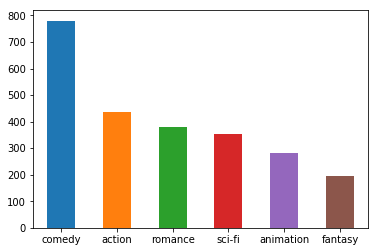

In [33]:
df.tag.value_counts().plot(kind="bar", rot=0)

In [34]:
float(df.tag.value_counts()['comedy']) / df.tag.value_counts().sum() 

0.32138442521631644

Data has a skewed distribution among the classes. A dumb classifier that always predicts 'comedy' achieves an accuracy of **32%**.

In [35]:
pd.set_option('display.max_colwidth', -1)
df.sample(20)

,Unnamed: 0,movieId,plot,tag
1509,1509,65230,"A family learns important life lessons from their adorable, but naughty and neurotic dog.",comedy
1770,1770,83134,Tucker and Dale are on vacation at their dilapidated mountain cabin when they are attacked by a group of preppy college kids.,comedy
2428,2428,143245,"From Mark Osborne comes the first-ever animated feature film adaptation of Antoine de Saint-Exupry's iconic masterpiece, The Little Prince. At the heart of it all is The Little Girl, who's being prepared by her mother for the very grown-up world in which they live - only to be interrupted by her eccentric, kind-hearted neighbor, The Aviator. The Aviator introduces his new friend to an extraordinary world where anything is possible. A world that he himself was initiated into long ago by The Little Prince. It's here that The Little Girl's magical and emotional journey into her own imagination - and into the universe of The Little Prince - begins. And it's where The Little Girl rediscovers her childhood and learns that ultimately, it's human connections that matter most, and that what's truly essential can only be seen with the heart.",animation
1709,1709,78893,"Follows the adventures of Aang, a young successor to a long line of Avatars, who must master all four elements and stop the Fire Nation from enslaving the Water Tribes and the Earth Kingdom.",fantasy
1738,1738,80489,"As he plans his next job, a longtime thief tries to balance his feelings for a bank manager connected to one of his earlier heists, as well as the FBI agent looking to bring him and his crew down.",action
1299,1299,48660,"Based on Michel Houellebecq's controversial novel, this movie focuses on Michael and Bruno, two very different half-brothers and their disturbed sexuality. After a chaotic childhood with a hippie mother only caring for her affairs, Michael, a molecular biologist, is more interested in genes than women, while Bruno is obsessed with his sexual desires, but mostly finds his satisfaction with prostitutes. His pitiful life changes when he gets to know the experienced Christiane. In the meantime, Michael meets Annabelle, the love of his youth, again...",romance
1960,1960,96079,"Bond's loyalty to M is tested when her past comes back to haunt her. Whilst MI6 comes under attack, 007 must track down and destroy the threat, no matter how personal the cost.",action
961,961,7254,"Evan Treborn suffers blackouts during significant events of his life. As he grows up, he finds a way to remember these lost memories and a supernatural way to alter his life by reading his journal.",sci-fi
1175,1175,33794,"After training with his mentor, Batman begins his war on crime to free the crime-ridden Gotham City from corruption that the Scarecrow and the League of Shadows have cast upon it.",action
918,918,6800,"A gang of neo-fascist thugs, led by the self-proclaimed 'Night Slasher', are breaking into people's homes & cars, then killing them at random. When of of these thugs holds up a food store & takes hostages, Lt. Marian Cobretti - an intense, take-no-prisoners cop, is brought onto the scene to end the hostage-taking. Ranting bizarrely about a 'New World', the man levels a sawed-off shotgun at Cobretti, who hits him with a knife, then guns him down when the man refuses to put down his weapon. Later that night, another murder occurs, attributed to the Night Slasher - and the next day, another one. This one is witnessed by a young woman, Ingrid Knutsen. She drives away before the thugs can kill her, but it isn't long before some creepy-looking people start making attempts on her life - and Cobretti's. Cobretti plans to move the only witness to the blood spree upstate, but with inside information, the thugs follow them. And a battle for survival rages between Cobretti and the thugs...",action


In [36]:
train_data, test_data = train_test_split(df, test_size=0.1, random_state=42)

In [37]:
print('Number of training examples: %d' % len(train_data))
print('Number of tesing examples: %d' % len(test_data))

Number of training examples: 2184
Number of tesing examples: 243


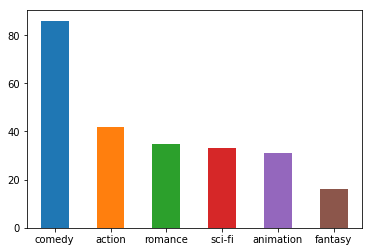

In [38]:
test_data.tag.value_counts().plot(kind="bar", rot=0)
my_tags = ['sci-fi' , 'action', 'comedy', 'fantasy', 'animation', 'romance']

### Model Evaluation

In [39]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(my_tags))
    target_names = my_tags
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [40]:
def evaluate_prediction(predictions, target, title="Confusion matrix"):
    print('accuracy %s' % accuracy_score(target, predictions))
    cm = confusion_matrix(target, predictions)
    print('confusion matrix\n %s' % cm)
    print('(row=expected, col=predicted)')
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized, title + ' Normalized')

### Tokenize text

In [41]:
def custom_tokenize_text(text):
    filters = [strip_punctuation, strip_numeric, strip_multiple_whitespaces, strip_short]
    cleaned_words = [word for word in preprocess_string(text, filters=filters)]
    if cleaned_words:
        return cleaned_words

### Prepare data

In [42]:
# prepare training data
X_train = []
y_train = []
for plot, tag in train_data[['plot', 'tag']].values:
    X_train.append(custom_tokenize_text(plot))
    y_train.append(tag)
X_train, y_train = np.array(X_train), np.array(y_train)

In [43]:
print(len(X_train), len(y_train))
print(y_train[0])
print(X_train[0])

2184 2184
comedy
['Turkish', 'and', 'his', 'close', 'friend', 'accomplice', 'Tommy', 'get', 'pulled', 'into', 'the', 'world', 'match', 'fixing', 'the', 'notorious', 'Brick', 'Top', 'Things', 'get', 'complicated', 'when', 'the', 'boxer', 'they', 'had', 'lined', 'gets', 'badly', 'beaten', 'Pitt', 'pikey', 'slang', 'for', 'Irish', 'Gypsy', 'who', 'comes', 'into', 'the', 'equation', 'after', 'Turkish', 'unlicensed', 'boxing', 'promoter', 'wants', 'buy', 'caravan', 'off', 'the', 'Irish', 'Gypsies', 'They', 'then', 'try', 'convince', 'Pitt', 'not', 'only', 'fight', 'for', 'them', 'but', 'lose', 'for', 'them', 'too', 'Whilst', 'all', 'this', 'going', 'huge', 'diamond', 'heist', 'takes', 'place', 'and', 'fistful', 'motley', 'characters', 'enter', 'the', 'story', 'including', 'Cousin', 'Avi', 'Boris', 'The', 'Blade', 'Franky', 'Four', 'Fingers', 'and', 'Bullet', 'Tooth', 'Tony', 'Things', 'from', 'bad', 'worse', 'all', 'becomes', 'about', 'the', 'money', 'the', 'guns', 'and', 'the', 'damned', '

In [44]:
# prepare test data
X_test = []
y_test = []
for plot, tag in test_data[['plot', 'tag']].values:
    X_test.append(custom_tokenize_text(plot))
    y_test.append(tag)
X_test, y_test = np.array(X_test), np.array(y_test)

In [45]:
len(X_test), len(y_test)

(243, 243)

## Technique 1: Bag-of-Words(BoW) + Linear SVM

### CountVectorizer

In [46]:
from sklearn.feature_extraction.text import CountVectorizer
# list of text documents
text = ["The quick brown fox jumped over the lazy dog."]
# create the transform
vectorizer = CountVectorizer()
# tokenize and build vocab
vectorizer.fit(text)
# summarize
print(sorted(vectorizer.vocabulary_.items(), key=operator.itemgetter(1)))
# encode document
vector = vectorizer.transform(text)
# summarize encoded vector
print(vector.shape)
print(type(vector))
print(vector.toarray())

[('brown', 0), ('dog', 1), ('fox', 2), ('jumped', 3), ('lazy', 4), ('over', 5), ('quick', 6), ('the', 7)]
(1, 8)
<class 'scipy.sparse.csr.csr_matrix'>
[[1 1 1 1 1 1 1 2]]


In [47]:
bow_svc = Pipeline([("count_vectorizer", CountVectorizer(analyzer=lambda x: x)), ("linear_svc", LinearSVC())])

### Train classifier - Word Counts feature + Linear SVC

In [48]:
%%time
bow_svc.fit(X_train, y_train)

CPU times: user 180 ms, sys: 4 ms, total: 184 ms
Wall time: 182 ms


Pipeline(memory=None,
     steps=[('count_vectorizer', CountVectorizer(analyzer=<function <lambda> at 0x7fb7acfc8ea0>, binary=False,
        decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), prepro...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

### Get predictions

In [49]:
y_pred_bow_svc = bow_svc.predict(X_test)

accuracy 0.45267489711934156
confusion matrix
 [[20  2 13  1  4  2]
 [ 5  9 12  2  2  1]
 [ 8  8 52  1 16  1]
 [ 2  2  4  4  1  3]
 [ 3  1 19  1  9  2]
 [ 5  3  7  1  1 16]]
(row=expected, col=predicted)


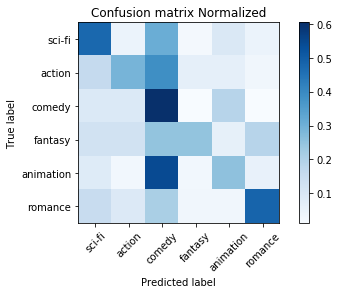

In [50]:
evaluate_prediction(y_pred_bow_svc, y_test)

Not bad - Bag of Words + Linear SVC shows more than 12-14% increase in accuracy compared to a classifier than always predicts comedy.

The next two techniques require a well trained word embeddings model. We use 'word2vec-google-news-300' (see description below).


Vocabulary size: 3 million words.

**Warning:** ~2 mins to load, takes 4 GB of RAM.

In case this is a problem, you could limit the number of vectors that you read.

In [51]:
api.info()['models']['word2vec-google-news-300']

{'base_dataset': 'Google News (about 100 billion words)',
 'checksum': 'a5e5354d40acb95f9ec66d5977d140ef',
 'description': "Pre-trained vectors trained on a part of the Google News dataset (about 100 billion words). The model contains 300-dimensional vectors for 3 million words and phrases. The phrases were obtained using a simple data-driven approach described in 'Distributed Representations of Words and Phrases and their Compositionality' (https://code.google.com/archive/p/word2vec/).",
 'file_name': 'word2vec-google-news-300.gz',
 'file_size': 1743563840,
 'license': 'not found',
 'num_records': 3000000,
 'parameters': {'dimension': 300},
 'parts': 1,
 'read_more': ['https://code.google.com/archive/p/word2vec/',
  'https://arxiv.org/abs/1301.3781',
  'https://arxiv.org/abs/1310.4546',
  'https://www.microsoft.com/en-us/research/publication/linguistic-regularities-in-continuous-space-word-representations/?from=http%3A%2F%2Fresearch.microsoft.com%2Fpubs%2F189726%2Frvecs.pdf'],
 'reade

In [53]:
%%time
path = api.load('word2vec-google-news-300', return_path=True)
w2v_model = KeyedVectors.load_word2vec_format(path, binary=True, limit=200000)
# you can load all vectors using one line
# w2v_model = api.load('word2vec-google-news-300')

2018-03-17 18:35:14,829 : INFO : loading projection weights from /home/cva/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz
2018-03-17 18:35:20,010 : INFO : loaded (200000, 300) matrix from /home/cva/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz


CPU times: user 5.16 s, sys: 145 ms, total: 5.3 s
Wall time: 5.66 s


In [54]:
%%time
w2v_model.init_sims(replace=True)

2018-03-17 18:35:24,975 : INFO : precomputing L2-norms of word weight vectors


CPU times: user 1.41 s, sys: 53 µs, total: 1.41 s
Wall time: 1.41 s


## Technique 2: Average word embeddings + Linear SVM

In [55]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = word2vec.vector_size
    
    def fit(self, X, y):
        return self 

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [56]:
avg_wv_svc = Pipeline([("mean_embedding_vectorizer", MeanEmbeddingVectorizer(w2v_model)), ("linear_svc", LinearSVC())])

In [57]:
avg_wv_svc.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('mean_embedding_vectorizer', <__main__.MeanEmbeddingVectorizer object at 0x7fb7ac4e8400>), ('linear_svc', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

In [58]:
y_pred_avg_wv_svc = avg_wv_svc.predict(X_test)

accuracy 0.5967078189300411
confusion matrix
 [[26  1 12  0  1  2]
 [ 2 10 13  1  2  3]
 [ 4  0 77  0  4  1]
 [ 2  1  7  3  0  3]
 [ 2  0 21  1  9  2]
 [ 7  0  6  0  0 20]]
(row=expected, col=predicted)


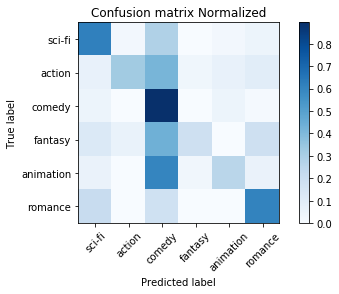

In [59]:
evaluate_prediction(y_pred_avg_wv_svc, y_test)

We saw 2 techniques to classify texts. The results here do not indicate the best achievable performance using these techniques. Potential ways to increase the performance of these techniques is by using some other supervised classifier (instead of linear SVC) and ofcourse tuning the classifier.

## Are average word embeddings any good?
>The prevailing view is that it lacks the ability to capture semantics of word sequences and is virtually useless for most purposes, unless combined with heavy machinery.

While classification using simple word embeddings averaging may not be best model, it does provide a **decent baseline** on most tasks.

There are several papers that challenge the above quoted view and point out the significant boost in accuracy (performing competitive to state-of-art) with small modifications to average word embeddings. These discussions are out of the scope this workshop. Below are a few link to some of the papers:
- ["Deep Unordered Composition Rivals Syntactic Methods for Text Classification"](https://www.cs.umd.edu/~miyyer/pubs/2015_acl_dan.pdf)
- ["In Defense of Word Embedding for Generic Text Representation"](https://www.semanticscholar.org/paper/In-Defense-of-Word-Embedding-for-Generic-Text-Repr-Lev-Klein/a0c098337a726274db31bc5ec67d17c29c5e7eae)
- ["All-but-the-Top: Simple and Effective Postprocessing for Word Representations"](https://arxiv.org/pdf/1702.01417.pdf)
- ["A Simple But Tough-To-Beat Baseline For Sentence Embeddings"](https://openreview.net/pdf?id=SyK00v5xx)


## References
A lot of the code used in this notebook as been picked up directly/modified from various other tutorials/blogs/notebooks. Thanks to all of you guys to help speed up the creation of this notebook.
- https://github.com/RaRe-Technologies/movie-plots-by-genre/blob/master/Document%20classification%20with%20word%20embeddings%20tutorial.ipynb - Lev Konstantinovskiy.
- http://sujitpal.blogspot.in/2016/04/predicting-movie-tags-from-plots-using.html - Sujit Pal.
- http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/ - Nadbor Drozd.
- https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/ - Jason Brownlee.

# Appendix

<a id='solution1'></a>
### Solution to Exercise1

In [22]:
def find_analogy(model, wordA, wordB, wordC):
    resultant_vector = model.wv.word_vec(wordB, use_norm=True) + model.wv.word_vec(wordC, use_norm=True) - model.wv.word_vec(wordA, use_norm=True)
    return model.wv.similar_by_vector(resultant_vector, topn=5)

In [23]:
find_analogy(model_text8, 'king', 'man', 'queen')

[('man', 0.8756952285766602),
 ('woman', 0.8381981253623962),
 ('girl', 0.7609813809394836),
 ('lady', 0.6938247084617615),
 ('love', 0.6851938962936401)]

Are you surprised by the results? Why is 'woman' not the closest but it's rather 'man'. The explanation for this is a little out of scope of this tutorial. Have a look at this [video](https://www.coursera.org/learn/language-processing/lecture/lpSIA/word-analogies-without-magic-king-man-woman-queen) in case you are interested. 

In [24]:
# a general `Gensim` API for the same purpose as exercise 1
model_text8.wv.most_similar(positive=['man', 'queen'], negative=['king'], topn=3)

[('woman', 0.8381981253623962),
 ('girl', 0.7609813809394836),
 ('lady', 0.6938247084617615)]

[Back to Exercise 1](#exercise1)

<a id='solution2'></a>
### Solution to Exercise2

In [25]:
def oddword(words_list):
    words_norm_vectors = np.array([model_text8.wv.word_vec(word, use_norm=True) for word in words_list])
    vectors_mean = np.sum(words_norm_vectors, axis=0) / float(len(words_list))
    odd_word_index = np.argsort(model_text8.wv.cosine_similarities(vectors_mean, words_norm_vectors))[0]
    return words_list[odd_word_index]

In [26]:
oddword(['summer', 'winter', 'spring', 'cold'])

'cold'

In [27]:
# a general `Gensim` API for the same purpose as exercise 2
model_text8.wv.doesnt_match(['summer', 'winter', 'spring', 'cold'])

'cold'

[Back to Exercise 2](#exercise2)